<a href="https://colab.research.google.com/github/Parvez-Mondol/fashion-cnn-210114/blob/main/21014_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image
from sklearn.metrics import confusion_matrix
from tensorflow import keras


In [44]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(X_train.shape, y_train.shape)


(60000, 28, 28) (60000,)


In [45]:
X_train = X_train / 255.0
X_test  = X_test / 255.0

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)


In [46]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [47]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [49]:
epochs = 10

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(loss_sum / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_losses.append(loss_sum / len(test_loader))
    test_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | Test Acc: {test_accs[-1]:.4f}")


Epoch 1/10 | Train Acc: 0.8075 | Test Acc: 0.8603
Epoch 2/10 | Train Acc: 0.8727 | Test Acc: 0.8796
Epoch 3/10 | Train Acc: 0.8918 | Test Acc: 0.8927
Epoch 4/10 | Train Acc: 0.9033 | Test Acc: 0.8864
Epoch 5/10 | Train Acc: 0.9125 | Test Acc: 0.8989
Epoch 6/10 | Train Acc: 0.9208 | Test Acc: 0.9015
Epoch 7/10 | Train Acc: 0.9255 | Test Acc: 0.9012
Epoch 8/10 | Train Acc: 0.9328 | Test Acc: 0.9054
Epoch 9/10 | Train Acc: 0.9373 | Test Acc: 0.8967
Epoch 10/10 | Train Acc: 0.9418 | Test Acc: 0.9055


In [50]:
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), "model/190110.pth")


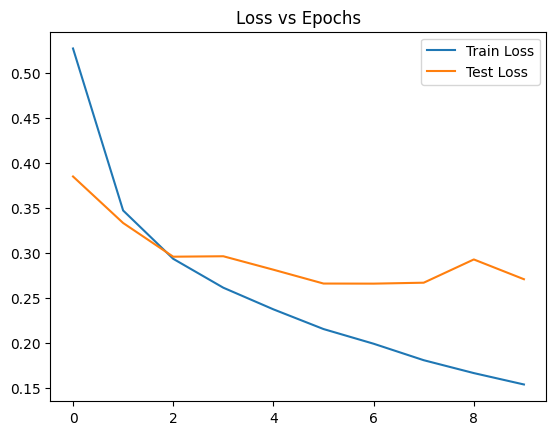

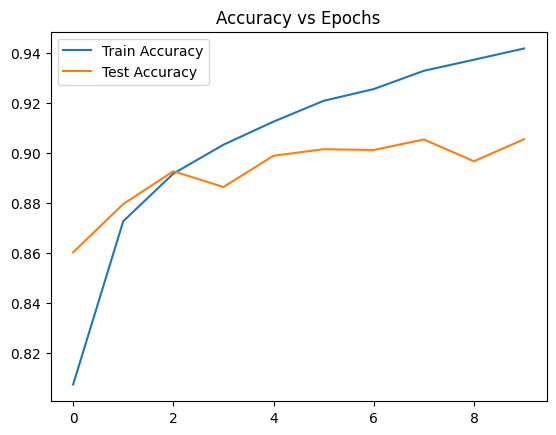

In [51]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()


In [52]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


In [53]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [54]:
cm = confusion_matrix(all_labels, all_preds)


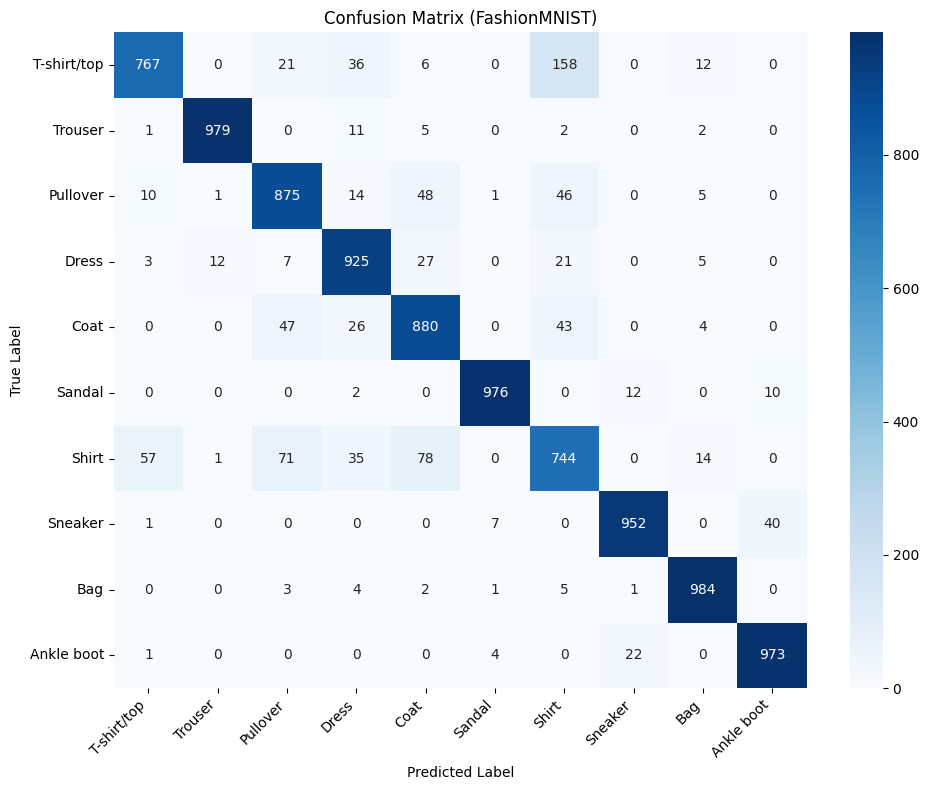

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (FashionMNIST)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# Average loss and accuracy
test_loss /= len(test_loader)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.2708
Test Accuracy: 90.55%


In [57]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [58]:
import requests
from io import BytesIO

In [59]:
api_url = "https://api.github.com/repos/Parvez-Mondol/fashion-cnn-210114/contents/dataset"
response = requests.get(api_url)
files = response.json()

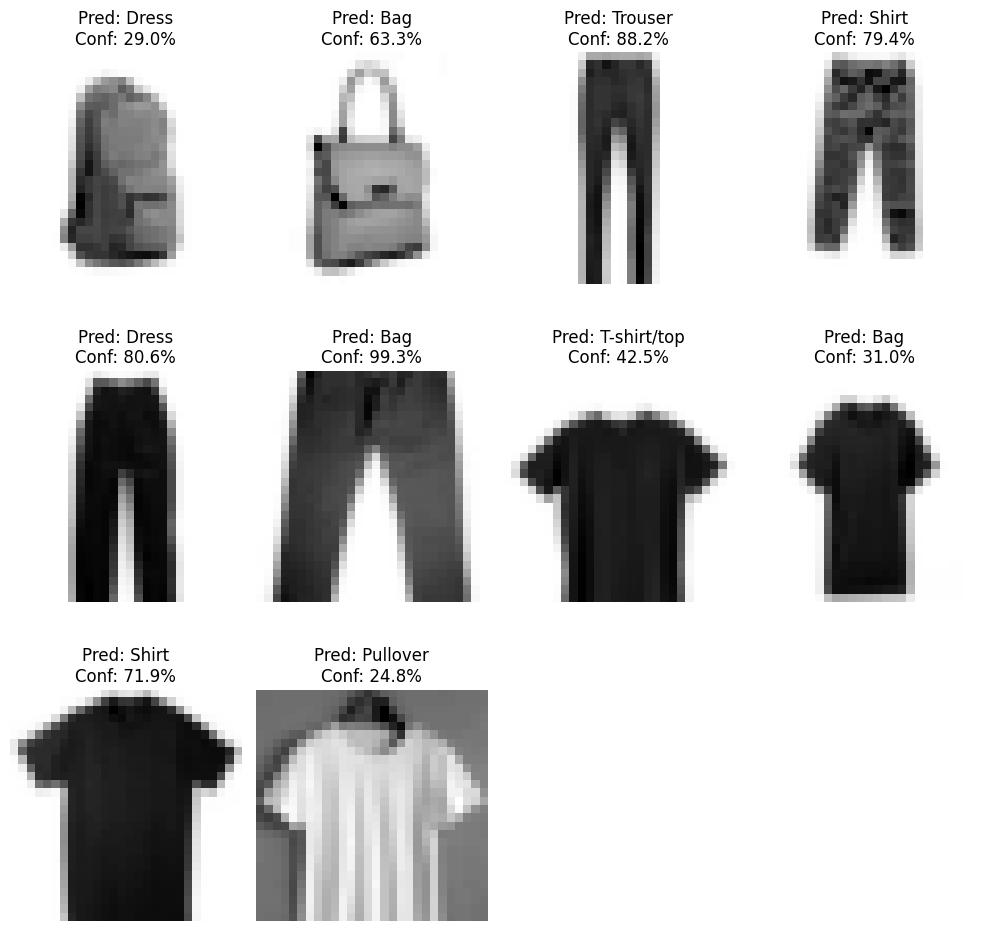

In [60]:
model.eval()
plt.figure(figsize=(10,10))

i = 0
for file in files:
    if file["type"] != "file":
        continue

    img_name = file["name"]
    if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # RAW image URL
    img_url = file["download_url"]

    # Download image
    img = Image.open(BytesIO(requests.get(img_url).content)).convert("L")

    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    plt.subplot(3,4,i+1)
    plt.imshow(img_tensor.squeeze().cpu(), cmap='gray')
    plt.title(f"Pred: {class_names[pred.item()]}\nConf: {conf.item()*100:.1f}%")
    plt.axis('off')

    i += 1
    if i == 12:
        break

plt.tight_layout()
plt.show()

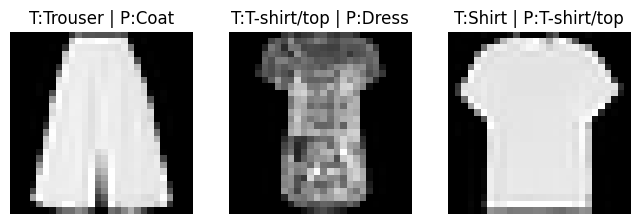

In [61]:
wrong = [(i, all_preds[i], all_labels[i])
         for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

sample = np.random.choice(len(wrong), 3, replace=False)

plt.figure(figsize=(8,4))
for idx, s in enumerate(sample):
    i, pred, true = wrong[s]
    img, _ = test_dataset[i]
    plt.subplot(1,3,idx+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"T:{class_names[true]} | P:{class_names[pred]}")
    plt.axis("off")
plt.show()